# Michelle Static experiment

Electrode A (old)
1e-9 total Cu
1e-5 EN
pH 10

"1e-9 Cu static.xlsx"

In [1]:
% housekeeping
% clear data and number format
clear; format short e
% turn off warnings
warning off
graphics_toolkit ("notebook"); 
%graphics_toolkit ("plotly"); 
% setup environment
% set path to equilibrium solver
txt=pwd;
n=length(txt);
rootpath=txt(1:n-12);
PHREEQCpath=[rootpath,'/runPHREEQC'];
addpath(PHREEQCpath);
JEQUILIBpath=[rootpath,'/JEQUILIB']; addpath(JEQUILIBpath);
Cumodelspath=[rootpath,'/Cu_EN']; addpath(Cumodelspath);

In [2]:
% put in constants
VT=0.05; %total volume
stockCuconc=0.000157366; %M
ENT=1e-5;

In [3]:
% put in data

originalsamplemVnpH=[...
%pH mV
%9.440  -174.4
%9.343  -171.4
9.336  -170.4
];

calibdata=[...
%volCu mV pH
%0 -21.8  2.022
50 16.4 2.058
100 22.7 1.996
250 35.1 2.051
500 53.1 2.022
1000 84.8 2.004
];


pH = 9.3360e+00


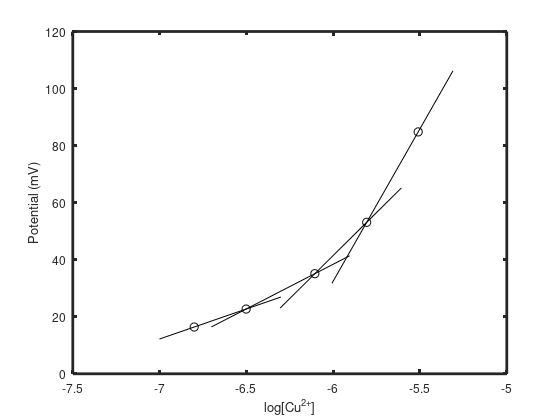

In [4]:
graphics_toolkit("notebook")
% pull out the sample data
pH=mean(originalsamplemVnpH(:,1))
mVoriginal=(originalsamplemVnpH(:,2));

%pull out the calibration data
addedCuvol=calibdata(:,1)'*1e-6; pHcalib=calibdata(:,3); mV=calibdata(:,2)'; 
CuTmeas=1e-9; % not actually known until it is measured 
CuT=CuTmeas; CuTplus=(CuTmeas*(VT)+addedCuvol*stockCuconc)./(VT+addedCuvol);

plot(log10(CuTplus),mV,'ko'); hold on

%chlorocorrecxtion
%BF1=2.49; BF2=1.14; BF3=0.9; ClT=4.9904e-4; %from Inorg. Chem. 1983. 22. 3323-3326.
%CuTplus=CuTplus./(1+BF1*ClT+BF2*ClT^2+BF3*ClT^3);

%determine all the slopes and intercepts for each pair of mV values
for i=1:length(mV)-1
    param=polyfit([log10(CuTplus(i)) log10(CuTplus(i+1))],[mV(i) mV(i+1)],1);
    val=polyval(param,[log10(CuTplus(i))-0.2 log10(CuTplus(i+1))+0.2]);
    plot([log10(CuTplus(i))-0.2 log10(CuTplus(i+1))+0.2],val,'k-')
    m(i)=param(1); Eo(i)=param(2); 
    %two ways to define what logCu is for the Eo and m values. need to pick the approach that consistently works best
    logCuT(i)=mean([log10(CuTplus(i)) log10(CuTplus(i+1))]); % calib Cu is the midpoint
    %logCuT(i)=[log10(CuTplus(i))]; % calib Cu is the starting point 
end
xlabel('log[Cu^{2+}]');  ylabel('mV');
set(gca,'fontsize',12); set(gca,'linewidth',2);
xlabel('log[Cu^{2+}]'); ylabel('Potential (mV)')

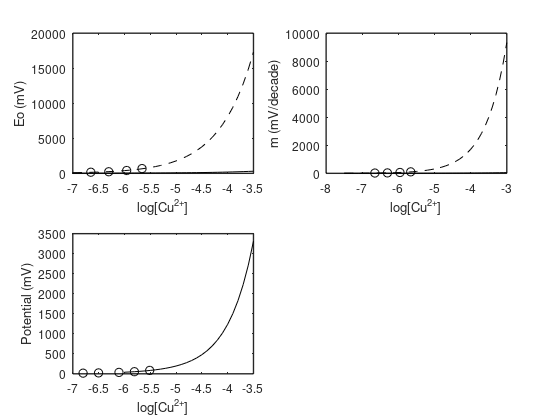

In [5]:
%plot and fit the s and Eo curves to an exponential function

subplot(221); plot(logCuT,Eo,'ko'); subplot(222); plot(logCuT,m,'ko');
%a=1000; b=0.3; x=logCuT; y=a*exp(b*x)
%subplot(221); hold on; plot(x,y,'k--')
%use exponential
%define function
exponentialfunction = @(p,logx) (p(1)*exp(p(2)*logx));
%errfunction=@(p,logx,meas) (log10(sum((meas-exponentialfunction(p,logx)).^2)));
errfunction=@(p,logx,meas) ((sum((meas-exponentialfunction(p,logx)).^2)));

%fit Eo to meta calibration
ptst=[10000 1];
logx=-7:0.1:-3.5; model=exponentialfunction(ptst,logx);
err=errfunction(ptst,logCuT,Eo);
subplot(221); hold on
plot(logx,model,'k-')
%now best fit
options = optimset('Display','off','TolFun',1e-6,'TolX',1e-6);
pbestEo=fminsearch(@(p) errfunction(p,logCuT,Eo),ptst,options);
model=exponentialfunction(pbestEo,logx);
plot(logx,model,'k--')

%fit m to meta calibration
ptst=[1000 1];
logx=-7.5:0.1:-3; model=exponentialfunction(ptst,logx);
err=errfunction(ptst,logCuT,m);
subplot(222); hold on
plot(logx,model,'k-')
% now best fit
options = optimset('Display','off','TolFun',1e-6,'TolX',1e-6);
pbestm=fminsearch(@(p) errfunction(p,logCuT,m),ptst,options);
model=exponentialfunction(pbestm,logx);
plot(logx,model,'k--')

%plot the original data and the metacalibration fit
subplot(223)
plot(log10(CuTplus),mV,'ko'); hold on
logCuTplot=-6:0.1:-3.5 ;
for i=1:length(logCuTplot)
    Eocalc=exponentialfunction(pbestEo,logCuTplot(i));
    mcalc=exponentialfunction(pbestm,logCuTplot(i));
    mVcalc(i)=Eocalc+mcalc*logCuTplot(i);
end
plot(logCuTplot,mVcalc,'k-')

subplot(221); set(gca,'fontsize',12); set(gca,'linewidth',1);
xlabel('log[Cu^{2+}]'); ylabel('Eo (mV)')
    
subplot(222); set(gca,'fontsize',12); set(gca,'linewidth',1);
xlabel('log[Cu^{2+}]'); ylabel('m (mV/decade)')

subplot(223); set(gca,'fontsize',12); set(gca,'linewidth',1);
xlabel('log[Cu^{2+}]'); ylabel('Potential (mV)')


In [6]:
% then use this metacalibration to determine original sample logCu2+

Eooriginal=exponentialfunction(pbestEo,log10(CuT))
moriginal=exponentialfunction(pbestm,log10(CuT))

Eooriginal=mean(Eo(1))*1
moriginal=mean(m(1))*1

logCuoriginal=(mVoriginal-Eooriginal)/moriginal

Eooriginal = 4.0390e+00


moriginal = 3.5910e-01


Eooriginal = 1.5959e+02


moriginal = 2.1055e+01


logCuoriginal = -1.5673e+01


Cuall = 6.3687e-18


CuOH = 4.1656e-16


CuOH2s =          0


CuOs =          0


CuCO3s =          0


tenorite =          0


malachite =          0


MASSERR = 6.7763e-21


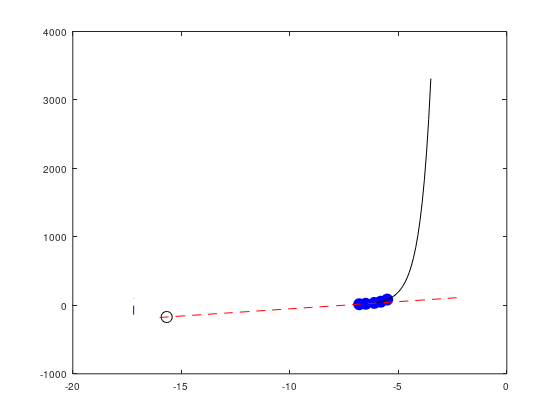

In [7]:
% MODEL FOR COMPARISON
graphics_toolkit("notebook")
%model with just inorganic speciation
%geochemical model
% input the constants and solution chemistry

flag1=2; %flag1 for concentration based search vector (1) or for log based search vector (2).
flag2=1; %flag2 for numerical derivatives (2) or analtyical derivatives (1)
database=[]; 
flag3=0; % flag3 1 for show warnings. 0 no warnings
flag4=0; %if=1 solve tableau one line at a time to get a good initial guess (no solids). really challenging probs only
flag5=0; %if=1 use stored initial guess for including solids

CuT=CuTmeas; inorganicTOTALS=[CuT ENT];
inorganicTOTALS(inorganicTOTALS==0)=1e-16; % get rid of zero values, b/c div by zero error
TOTALS=[inorganicTOTALS]; %TOTALS=inorganicTOTALS;
pH=pH; pe=20.75-pH; PCO2=10^-3.5;
[Cuall,CuOH,CuOH2s,CuOs,CuCO3s,tenorite,malachite,MASSERR]=CuOHCO2open_EN_allsolids(pH,pe,PCO2,TOTALS',flag1,flag2,flag3,flag4,flag5,database)

plot(log10(CuTplus),mV,'bo','markersize',8,'markerfacecolor','b'); 
hold on
plot(logCuTplot,mVcalc,'k-')
plot(logCuoriginal,mVoriginal,'ko','markersize',8)

% show calibration
logCuplot=-16:1:-2; Ecalc=Eooriginal+moriginal*logCuplot;
plot(logCuplot,Ecalc,'r--')

plot([log10(Cuall) log10(Cuall)],[min(mVoriginal)-0.2*min(mVoriginal) max(mV)+0.2*max(mV)],'b--')